In [173]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [174]:
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv')

In [175]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])

In [176]:
dangjin_fcst

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0,2018-03-01 11:00:00
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0,2018-03-01 11:00:00
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0,2018-03-01 11:00:00
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0,2018-03-01 11:00:00
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0,2018-03-01 11:00:00
...,...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,7.0,40.0,3.2,187.0,1.0,2021-03-01 08:00:00
162204,2021-03-01 08:00:00,55.0,8.0,40.0,4.5,217.0,1.0,2021-03-01 08:00:00
162205,2021-03-01 08:00:00,58.0,5.0,55.0,2.2,210.0,1.0,2021-03-01 08:00:00
162206,2021-03-01 08:00:00,61.0,1.0,80.0,1.9,164.0,1.0,2021-03-01 08:00:00


In [177]:
fcst_dj_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour ==14]

14시 예보만 사용

In [178]:
fcst_dj_14 = fcst_dj_14[(fcst_dj_14['forecast']>=10)&(fcst_dj_14['forecast']<=33)]


10시간 후(00시)~33시간 후(23시)까지의 데이터만 이용

In [179]:
fcst_dj_14 = fcst_dj_14[(fcst_dj_14['forecast'] >=10) & 
                        (fcst_dj_14['forecast'] <34)]

예보 시점에 forecast를 더해서 예보 시각 계산

In [180]:
def to_date(x):
    return pd.DateOffset(hours=x)

fcst_dj_14['Forecast_time'] = fcst_dj_14['Forecast_time'] +\
fcst_dj_14['forecast'].map(to_date)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [181]:
fcst_dj_14 = fcst_dj_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [182]:
fcst_dj_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
22,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
23,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
24,2018-03-02 06:00:00,-5.0,60.0,4.3,344.0,1.0
25,2018-03-02 09:00:00,-2.0,55.0,2.0,345.0,1.0
26,2018-03-02 12:00:00,1.0,45.0,0.8,256.0,1.0
...,...,...,...,...,...,...
162085,2021-03-01 09:00:00,8.0,90.0,3.9,64.0,4.0
162086,2021-03-01 12:00:00,10.0,90.0,4.8,7.0,4.0
162087,2021-03-01 15:00:00,10.0,85.0,6.6,11.0,4.0
162088,2021-03-01 18:00:00,7.0,85.0,6.5,34.0,4.0


In [183]:
fcst_dj_14_ = pd.DataFrame()
fcst_dj_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00',
                                          end='2021-03-01 23:00:00', freq='H')

In [184]:
fcst_dj_14_

,Forecast_time
0,2018-03-02 00:00:00
1,2018-03-02 01:00:00
2,2018-03-02 02:00:00
3,2018-03-02 03:00:00
4,2018-03-02 04:00:00
...,...
26299,2021-03-01 19:00:00
26300,2021-03-01 20:00:00
26301,2021-03-01 21:00:00
26302,2021-03-01 22:00:00


기존 예보 DataFrame와 병합

In [185]:
fcst_dj_14_ = pd.merge(fcst_dj_14_, fcst_dj_14, on='Forecast_time', how='outer')

In [186]:
fcst_dj_14_.head(20)

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN
5,2018-03-02 05:00:00,NaN,NaN,NaN,NaN,NaN
6,2018-03-02 06:00:00,-5.0,60.0,4.3,344.0,1.0
7,2018-03-02 07:00:00,NaN,NaN,NaN,NaN,NaN
8,2018-03-02 08:00:00,NaN,NaN,NaN,NaN,NaN
9,2018-03-02 09:00:00,-2.0,55.0,2.0,345.0,1.0


In [187]:
dangjin_fcst = fcst_dj_14_[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [188]:
for i in range(0, 8767) :
    dangjin_fcst['Temperature'][3*i+1] = fcst_dj_14_['Temperature'][3*i]
    dangjin_fcst['Temperature'][3*i+2] = fcst_dj_14_['Temperature'][3*i+3]
    dangjin_fcst['Humidity'][3*i+1] = fcst_dj_14_['Humidity'][3*i]
    dangjin_fcst['Humidity'][3*i+2] = fcst_dj_14_['Humidity'][3*i+3]
    dangjin_fcst['WindSpeed'][3*i+1] = fcst_dj_14_['WindSpeed'][3*i]
    dangjin_fcst['WindSpeed'][3*i+2] = fcst_dj_14_['WindSpeed'][3*i+3]
    dangjin_fcst['WindDirection'][3*i+1] = fcst_dj_14_['WindDirection'][3*i]
    dangjin_fcst['WindDirection'][3*i+2] = fcst_dj_14_['WindDirection'][3*i+3]
    dangjin_fcst['Cloud'][3*i+1] = fcst_dj_14_['Cloud'][3*i]
    dangjin_fcst['Cloud'][3*i+2] = fcst_dj_14_['Cloud'][3*i+3]

<ipython-input-188-170add10f92b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dangjin_fcst['Temperature'][3*i+1] = fcst_dj_14_['Temperature'][3*i]
<ipython-input-188-170add10f92b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dangjin_fcst['Temperature'][3*i+2] = fcst_dj_14_['Temperature'][3*i+3]
<ipython-input-188-170add10f92b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dangjin_fcst['Humidity'][3*i+1] = fcst_dj_14_['Humidi

In [189]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,-2.0,55.0,6.7,336.0,1.0
2,2018-03-02 02:00:00,-4.0,55.0,5.5,339.0,1.0
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,7.0,85.0,6.5,34.0,4.0
26300,2021-03-01 20:00:00,5.0,85.0,5.9,27.0,4.0
26301,2021-03-01 21:00:00,5.0,85.0,5.9,27.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


In [190]:
dangjin_fcst_2 = fcst_dj_14_[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [191]:
dangjin_fcst_2[ ['Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud'] ]= \
(dangjin_fcst[['Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']] +\
 fcst_dj_14_.interpolate()[[ 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']])/2

In [192]:
inter_fcst_14 = fcst_dj_14_.interpolate()

In [193]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,-2.0,55.0,6.7,336.0,1.0
2,2018-03-02 02:00:00,-4.0,55.0,5.5,339.0,1.0
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,7.0,85.0,6.5,34.0,4.0
26300,2021-03-01 20:00:00,5.0,85.0,5.9,27.0,4.0
26301,2021-03-01 21:00:00,5.0,85.0,5.9,27.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


In [194]:
dangjin_fcst_2

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.333333,55.000000,6.5,336.500000,1.0
2,2018-03-02 02:00:00,-3.666667,55.000000,5.7,338.500000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.166667,55.833333,5.3,339.833333,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.666667,85.000000,6.4,32.833333,4.0
26300,2021-03-01 20:00:00,5.333333,85.000000,6.0,28.166667,4.0
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


In [195]:
inter_fcst_14

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.333333,85.000000,6.3,31.666667,4.0
26300,2021-03-01 20:00:00,5.666667,85.000000,6.1,29.333333,4.0
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0
26302,2021-03-01 22:00:00,5.000000,85.000000,5.9,27.000000,4.0


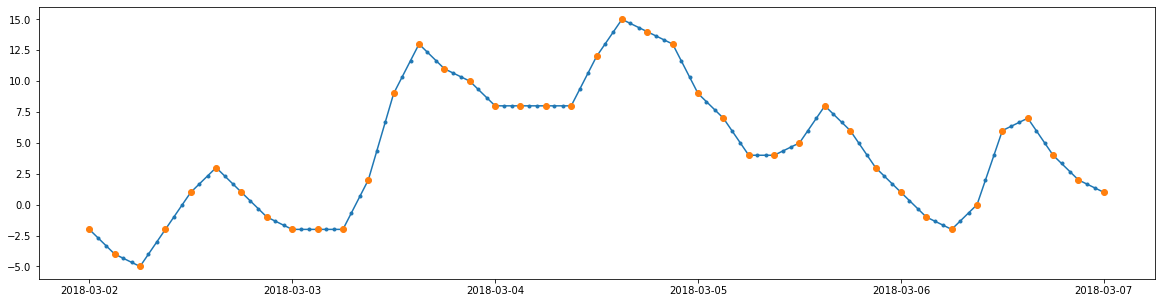

In [164]:
plt.figure(figsize=(20,5))
days = 5
plt.plot(inter_fcst_14.loc[:24*days, 'Forecast_time'], inter_fcst_14.loc[:24*days, 'Temperature'], '.-')
plt.plot(fcst_dj_14_.loc[:24*days, 'Forecast_time'], fcst_dj_14_.loc[:24*days, 'Temperature'], 'o')

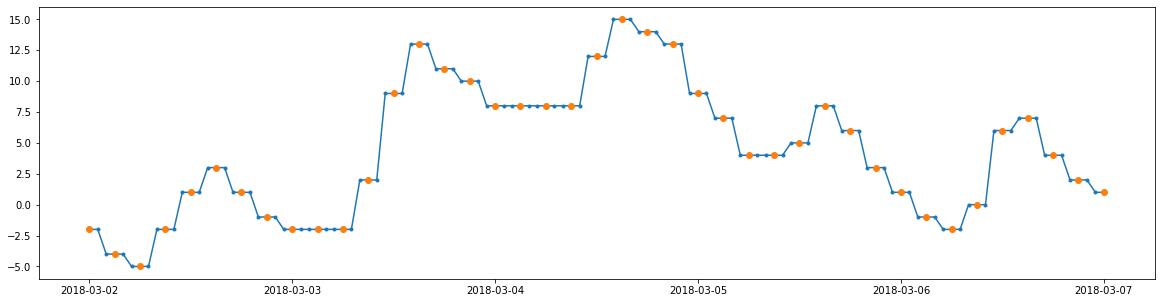

In [205]:
plt.figure(figsize=(20,5))
days = 5
plt.plot(dangjin_fcst.loc[:24*days, 'Forecast_time'], dangjin_fcst.loc[:24*days, 'Temperature'], '.-')
plt.plot(fcst_dj_14_.loc[:24*days, 'Forecast_time'], fcst_dj_14_.loc[:24*days, 'Temperature'], 'o')

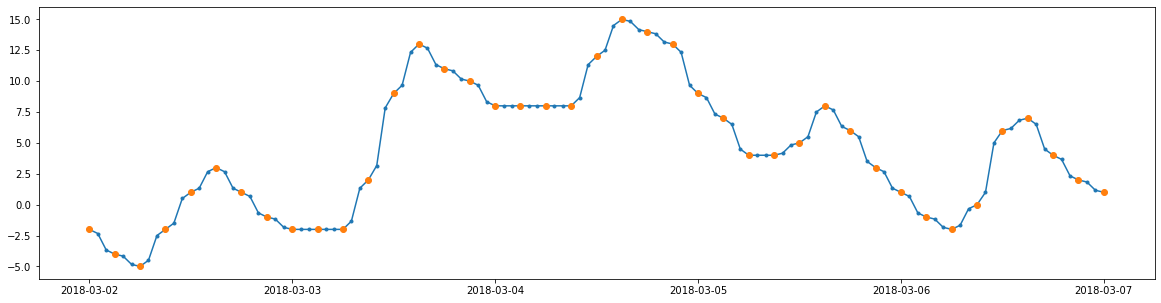

In [197]:
plt.figure(figsize=(20,5))
days = 5
plt.plot(dangjin_fcst_2.loc[:24*days, 'Forecast_time'], dangjin_fcst_2.loc[:24*days, 'Temperature'], '.-')
plt.plot(fcst_dj_14_.loc[:24*days, 'Forecast_time'], fcst_dj_14_.loc[:24*days, 'Temperature'], 'o')

In [206]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [207]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [208]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [209]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [210]:
dangjin_fcst_2['Forecast_time'] = dangjin_fcst_2['Forecast_time'].astype(str)
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
inter_fcst_14['Forecast_time'] = inter_fcst_14['Forecast_time'].astype(str)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 9
[LightGBM] [Info] Start training from score 247.345048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's l1: 55.5103	valid_0's score: 8.19728


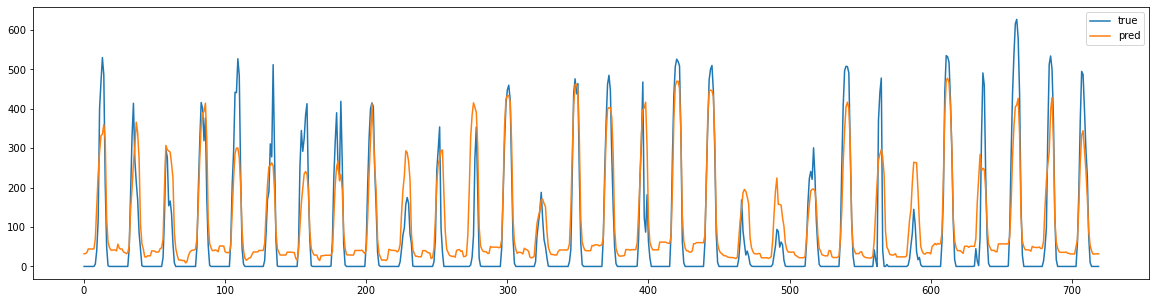

CV Score :  8.197275967964854


In [225]:
train_x, train_y, val_x, val_y = train_datast(energy, inter_fcst_14, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 9
[LightGBM] [Info] Start training from score 247.345048
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 41.358	valid_0's score: 8.06371
Early stopping, best iteration is:
[421]	valid_0's l1: 46.1328	valid_0's score: 7.93598


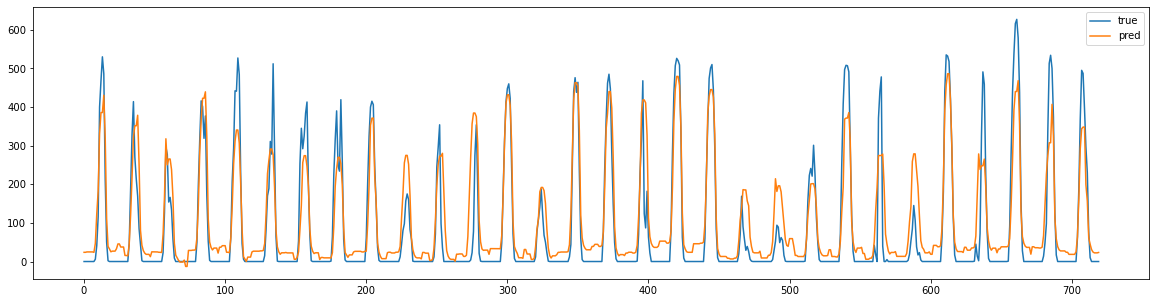

CV Score :  7.935976609335304


In [223]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 9
[LightGBM] [Info] Start training from score 247.345048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's l1: 66.1952	valid_0's score: 8.221


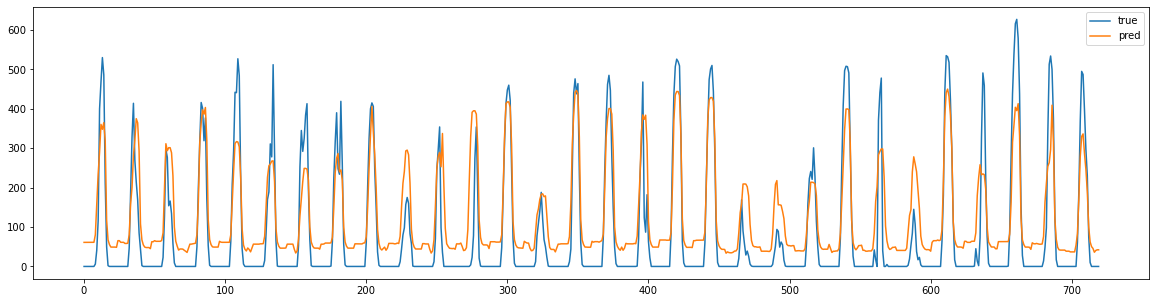

CV Score :  8.220996776317856


In [224]:


train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst_2, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [220]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,-2.0,55.0,6.7,336.0,1.0
2,2018-03-02 02:00:00,-4.0,55.0,5.5,339.0,1.0
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,7.0,85.0,6.5,34.0,4.0
26300,2021-03-01 20:00:00,5.0,85.0,5.9,27.0,4.0
26301,2021-03-01 21:00:00,5.0,85.0,5.9,27.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


In [221]:
dangjin_fcst_2

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0
1,2018-03-02 01:00:00,-2.333333,55.000000,6.5,336.500000,1.0
2,2018-03-02 02:00:00,-3.666667,55.000000,5.7,338.500000,1.0
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0
4,2018-03-02 04:00:00,-4.166667,55.833333,5.3,339.833333,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,6.666667,85.000000,6.4,32.833333,4.0
26300,2021-03-01 20:00:00,5.333333,85.000000,6.0,28.166667,4.0
26301,2021-03-01 21:00:00,5.000000,85.000000,5.9,27.000000,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN


In [144]:
dangjin_fcst

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,-2.0,55.0,6.7,336.0,1.0
1,2018-03-02 01:00:00,-2.0,55.0,6.7,336.0,1.0
2,2018-03-02 02:00:00,-4.0,55.0,5.5,339.0,1.0
3,2018-03-02 03:00:00,-4.0,55.0,5.5,339.0,1.0
4,2018-03-02 04:00:00,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...
26299,2021-03-01 19:00:00,NaN,NaN,NaN,NaN,NaN
26300,2021-03-01 20:00:00,NaN,NaN,NaN,NaN,NaN
26301,2021-03-01 21:00:00,5.0,85.0,5.9,27.0,4.0
26302,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN
